## Definitions

In [ ]:
# writing into excel library - uncomment the following line if needed
#%pip install openpyxl

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from main import simulate_apartment_stock, generate_interventions, simulate_social_housing, calculate_costs
from analysis import * 
import copy

idx = pd.IndexSlice

years = np.arange(15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model systému podpory v bydlení
## Cíle

* Zhodnotit přínosy a náklady zavedení systému podpory v bydlení
* Srovnat úspěšnost při řešení bytové nouze
* Představit základní logiku zákona

- [Ospravedlnění parametrů zde](https://mmrcz.sharepoint.com/:x:/r/sites/MMR-Zkonopodpoevbydlen/_layouts/15/guestaccess.aspx?share=EUy9k9Fw9JRLulyihYTMte8BSMkRlmAFsrVMBXySWvKGGg)

## Shrnutí modelu
- System dynamics model - domácnosti dostávají intervence směřující k řešení bytové nouze
- 2 typy domácností:
    - `High-risk` 
    - `Low risk`
- Každý rok se do bytové nouze dostanou další domácnosti. Zároveň ale do systému přijdou nové byty pro umístění 
- 2 typy intervencí:
- TODO lépe popsat buraucrat-centric interventions
    - *Měkké intervence* - dostane jí fixní podíl lidí čekajících ve frontě 
        - `self_help` - svépomoc bez asistence systému
        - `consulting` - Poradenství v síti KMB
        - `mop_payment` - dávka mimořádné okamžité pomoci - předpokládáme souběžné poradenství
    - *Bytové intervence* - pokud jsou k dispozici byty dané kategorie i zájemci o ně, budou přiděleny
        - `guaranteed` - Garanatované bydlení - soukromé byty se státními garancemi
        - `municipal` - obecní byty se sociálním zaměřením
- Domácnosti mění status:
    - `queue` - *Fronta* - Domácnosti v bytové nouzi čekající na pomoci
    - *Probíhající intervence* - označeno podle intervence výše
    - *Ukončená intervence* - outside, také rozlišeno dle intervence
- Vypořádání - tedy samotný modelling
    - Intervenci dostanou pouze lidé "ve frontě" 
    - Po konci intervence (která v případě bytů trvá několik let) se určitá část vrací zpátky do fronty tzv. *relapses*
    - Pokud relapsne `low risk` domácnost, přesune se do `high risk`
- Simulace probíhá 15 let
- Po vypořádání proběhne **vyúčtování**
    - Při vyúčtování se přilepí cenovky na jednotlivé intervence.
    - Druhy nákladů:
        - *Intervence - vstupní*
        - *Intervence - provozní*
        - *Systém - jednorázový*
        - *Systém - provozní*
        - *Náklady bytové nouze* - aplikuje se pro domácnosti ve frontě

## Poptávka - rozsah bytové nouze
* Také poptávka je modelována 2 druhy domácností
* Model prefenčně umísťuje `low-risk` domácnosti do `guaranteed` bytů a `high-risk` domácnosti do `municipal` bytů 
* Oba druhy domácností mají v čase lineární trend

### Dnešní stav bytové nouze
* Celkově je 60 000 domácností v bytové nouzi - z toho 70 % domácností jsou  `high risk` domácnosti a  30 % `low risk` domácnosti

### Budoucí vývoj bytové nouze
* Předpokládáme každoroční přísun dalších 9 000 domácností - z toho 65 % domácností jsou  *méně rizikové* domácnosti a  35 % *rizikové* domácnosti

In [2]:
current_level = 67500
high_current = .7
high_yearly = .35
household_size = 2.28
yearly_growth = 9100 

hhs_inflow = pd.Series({
    ('low','current_level'): (1 - high_current) * current_level,
    ('low','yearly_growth'): (1 - high_yearly) * yearly_growth,
    ('high','current_level'): high_current * current_level,
    ('high','yearly_growth'): high_yearly * yearly_growth,
}).unstack()
hhs_inflow

,current_level,yearly_growth
high,47250.0,3185.0
low,20250.0,5915.0


## Nabídka bytů

* Počet bytů v systému, které budou k dispozici pro domácnosti v bytové nouzi. 
* Nastavení modelu vede k (téměř) lineárnímu vkladu bytů do systému. Defaultní nastavení vede k tempu 2000 soukromých a pomalu rostoucích cca 700 -750 městských bytů v systému ročně.
* TODO zmínit, že frikce na bytech vstupuje spíše skrze nabízené byty a není třeba snižovat počet využívaných bytů

### Garantované byty
* Nabídka garantovaných bytů závisí primárně na konkurenceschopnosti podmínek pro pronajímatale a úspěšnosti komunikace
* Jejich počet proto je modelován jediným parametrem: `guaranteed_yearly_apartments`.

### Obecní byty
* Již dnes existuje cca 160 000 bytů - `municipal_apartments_today`
* Z již existujících bytů se každoročně 0,4% (varianta 1) či 0,2 % (varianta 0) uvolní do systému sociálního bydlení - `municipal_existing_availability_rate`
* I v budoucnu budou stavět nové městské byty - předpokládáme 300 bytů ročně - `municipal_yearly_new_apartments`
* Z nových bytů předpokládáme, že by do systému vstoupila výrazně větší část - 25 % ve variantě 1 a 10 % ve variantě 1 - `municipal_new_availability_rate`

In [3]:
guaranteed_yearly_apartments = 2000
municipal_apartments_today = 161100
municipal_yearly_new_apartments = 2000
municipal_existing_availability_rate = 0.004
municipal_new_availability_rate = 0.25

simulate_apartment_stock(
        guaranteed_yearly_apartments=guaranteed_yearly_apartments,
        municipal_apartments_today=municipal_apartments_today,
        municipal_yearly_new_apartments=municipal_yearly_new_apartments,
        municipal_existing_availability_rate=municipal_existing_availability_rate * 2,
        municipal_new_availability_rate=municipal_new_availability_rate,
        years=years
    ).diff()#.plot.bar(stacked=True, title='Počet dostupných bytů pro systém ve Variantě 1A')

,guaranteed,municipal
0,NaN,NaN
1,2000.0,1773.0
2,2000.0,1789.0
3,2000.0,1805.0
4,2000.0,1821.0
5,2000.0,1836.0
6,2000.0,1853.0
7,2000.0,1869.0
8,2000.0,1885.0
9,2000.0,1900.0


## Intervence a průchod domácnosti systémem

V každém roce proběhnou operace v následujícm sledu: 


1. Určení velikosti fronty (započítání relapses z minulého roku)
2. Měkké intervence (vždy podíl zbývajících domácností daného typu na frontě)
    1. `self_help` - některé domácnosti si zvládnou pomoci samy a dostanou se ven z BN
    2. `consulting` - další část domácností přijde pro poradenství na KMB a díky tomu se zvládnou dostat ven z BN
    3. `mop_payment` - další část domácností po konzultaci na KMB dostane vyplacenou dávku MOP
3. Bytové intervence (vždy porovnání počtu domácností daného typu ve frontě s počtem dostupných bytů)
    1. `Low risk` domácnosti do `guaranteed` bytů
    2. `High risk` domácnosti do `municipal` bytů
    3. `High risk` domácnosti do `guaranteed` bytů
    4. `Low risk` domácnosti do `municipal` bytů 

 Je třeba si uvědomit, že uvedené podíly se aplikují postupně a tedy postupně ubývá základ vůči kterému se podíly aplikují

 ### Intervenční podíly pro měkké intervence
 #### Varianta 0

In [4]:
intervention_shares_v0 = pd.Series({
    ('low','self_help'):.4, #
    ('low','consulting'):.0,
    ('low','mop_payment'):.02,
    ('high','self_help'):.15,
    ('high','consulting'):.0,
    ('high','mop_payment'):.02
}).unstack()
intervention_shares_v0

,consulting,mop_payment,self_help
high,0.0,0.02,0.15
low,0.0,0.02,0.40


#### Varianta 1 

In [5]:
intervention_shares_v1 = pd.Series({
    ('low','self_help'):.2,
    ('low','consulting'):.1,
    ('low','mop_payment'):.2,
    ('high','self_help'):.1,
    ('high','consulting'):.05,
    ('high','mop_payment'):.1
}).unstack()
intervention_shares_v1

,consulting,mop_payment,self_help
high,0.05,0.1,0.1
low,0.10,0.2,0.2


### Délka intervence

* Každá intervence má jinou dobu trvání
* Zatímco měkké intervence jsou jednorázové a z pohledu modelu trvají jeden rok, bydlení trvá déle

In [6]:
years_of_support = pd.Series({
    'municipal':3, 
    'guaranteed':2,
    'self_help':1,
    'mop_payment':1,
    'consulting':1
})
years_of_support

municipal      3
guaranteed     2
self_help      1
mop_payment    1
consulting     1
dtype: int64

### Relaps - neúspěšné intervence

* část domácností, se i přes to, že dostanou intervenci, se po čase zase vrátí do problémů
* Tomu model říká "relaps" - po konci intervenci domácnost neopouští systém, ale vrací se zpátky do fronty
* Tabulka níže ukazuje, jaká část domácností, které dostaly danou intervenci se po konci intervence vrací zpět do systému

In [7]:
relapse_rates_v1 = pd.Series({
    ('low','self_help'):.2,
    ('low','consulting'):.2,
    ('low','mop_payment'):.1,
    ('low','guaranteed'):.05,
    ('low','municipal'):.05,
    ('high','self_help'):.6,
    ('high','consulting'):.5,
    ('high','mop_payment'):.3,
    ('high','guaranteed'):.3,
    ('high','municipal'):.3
}).unstack()

relapse_rates_v1

,consulting,guaranteed,mop_payment,municipal,self_help
high,0.5,0.30,0.3,0.30,0.6
low,0.2,0.05,0.1,0.05,0.2


Vyšší relapse rates reflektují nedostupnost sociální péče (TODO není empirická literature?)

In [8]:
relapse_rates_v0 =  relapse_rates_v1.copy()
relapse_rates_v0.mop_payment = relapse_rates_v0.mop_payment * 1.5
relapse_rates_v0.loc['high',['guaranteed','municipal']] = 0.4
relapse_rates_v0.loc['low',['guaranteed','municipal']] = 0.1
relapse_rates_v0

,consulting,guaranteed,mop_payment,municipal,self_help
high,0.5,0.4,0.45,0.4,0.6
low,0.2,0.1,0.15,0.1,0.2


In [9]:
relapse_rates_v3 =  relapse_rates_v0.copy()
relapse_rates_v3.loc['high','guaranteed'] = 0.45
relapse_rates_v3.loc['low','guaranteed'] = 0.2
relapse_rates_v3.loc['high','municipal'] = 0.5
relapse_rates_v3.loc['low','municipal'] = 0.15

### Použití sociální asistence
* Sociální služby nejsou přímo modelovány, ale jsou přidělovány v určitém podílu a s měnící se délkou trvání
* Podíl intervenovaných, kteří zároveň s intervencí dostanou sociální asistenci a délku jejího trvání

#### Varianta 0

In [10]:
social_assistences_v0 = pd.Series({
    ('mop_payment','share'): .0,
    ('mop_payment','years'): 1,
    ('guaranteed','share'): .7,
    ('guaranteed','years'): 1,
    ('municipal','share'): .7,
    ('municipal','years'): 1,
}).unstack()

social_assistences_v0

,share,years
guaranteed,0.7,1.0
mop_payment,0.0,1.0
municipal,0.7,1.0


#### Varianta 1 

In [11]:
social_assistences_v1 = pd.Series({
    ('mop_payment','share'): .25,
    ('mop_payment','years'): 1,
    ('guaranteed','share'): .85,
    ('guaranteed','years'): 2,
    ('municipal','share'): .85,
    ('municipal','years'): 2,
}).unstack()

social_assistences_v1

,share,years
guaranteed,0.85,2.0
mop_payment,0.25,1.0
municipal,0.85,2.0


### Náklady intervencí

* Rozlišujeme tři druhy nákladů:
    * **Jednorázové** - Náklady, které je potřeba zadat pouze jednou - napříkald vývoj IT systému
    * **Fixní** - náklady existence systému sociálního bydlení, zcela nezávislé na výkonu - např. provoz IT systému.
    * **Vstupní** - náklady provedení intervence - například sehnání bytu do systému či vyplacení MOP
    * **Průběžné/Roční** - náklady probíhající intervence - náklady bytu


In [12]:
discount_rate = 0.04 # Impact assessment guidelines European Commission https://ec.europa.eu/smart-regulation/impact/commission_guidelines/docs/131210_cba_study_sg_final.pdf
intervention_costs_v1 = pd.Series({
    ('entry','self_help'):0,
    ('entry','mop_payment'):35126,
    ('entry','guaranteed'):15333, #16000 # Nezahrnuje poradenství - to je vyjádřeno fixní roční částkou
    ('entry','municipal'):0, # Nezahrnuje poradenství - to je vyjádřeno fixní roční částkou
    ('entry', 'social_assistance'): 0,
    ('yearly','self_help'):0,
    ('yearly','mop_payment'):0,
    ('yearly','guaranteed'):47333,
    ('yearly','municipal'):51333,
    ('yearly','social_assistance'): 80000,
    # 19 % inflation rate between 2020 and 2022 by CZSO; CNB Winter prediction 10.8 % (2023) and 2.1 % (2024); 
    ('yearly','queue_budget'): 1.19 * 1.108 * household_size * 20303, #47915, # https://drive.google.com/drive/u/0/folders/1AB-eICOTy3LndCi75t68i2aCKKgxXlrd p.47
    ('yearly','queue_social'): 146712,
    ('one_off','IT_system'):20000000,
    ('yearly','IT_system'):2000000,
    ('yearly','regional_administration'): 56652248, 
    ('yearly','consulting'): 439092660,
    ('one_off','consulting'): 406901511-439092660# Consulting costs less in the first year. Adjustment done via one_off component
}).unstack()
intervention_costs_v1.T

,entry,one_off,yearly
IT_system,NaN,20000000.0,2.000000e+06
consulting,NaN,-32191149.0,4.390927e+08
guaranteed,15333.0,NaN,4.733300e+04
mop_payment,35126.0,NaN,0.000000e+00
municipal,0.0,NaN,5.133300e+04
queue_budget,NaN,NaN,6.103540e+04
queue_social,NaN,NaN,1.467120e+05
regional_administration,NaN,NaN,5.665225e+07
self_help,0.0,NaN,0.000000e+00
social_assistance,0.0,NaN,8.000000e+04


In [13]:
intervention_costs_v0 = intervention_costs_v1.copy()
intervention_costs_v0.loc ['yearly','IT_system'] = 0
intervention_costs_v0.loc ['yearly','regional_administration'] = 0
intervention_costs_v0.loc ['yearly','consulting'] = 0
intervention_costs_v0.loc ['one_off','consulting'] = 0
intervention_costs_v0.loc ['yearly','municipal'] = 0 
intervention_costs_v0.loc ['one_off','IT_system'] = 0

## Balíčky parametrů specifikujících varianty

### Varianta 0: Bez zákona

In [14]:
INPUT_0 = {
    'title': '0: Bez zákona',
    'years':years,
    'years_of_support':years_of_support,
    'intervention_costs':intervention_costs_v0,
    'guaranteed_yearly_apartments':0, 
    'municipal_apartments_today': municipal_apartments_today,
    'municipal_yearly_new_apartments': municipal_yearly_new_apartments,
    'municipal_existing_availability_rate': .002,
    'municipal_new_availability_rate': .1, 
    'relapse_rates':relapse_rates_v0,
    'intervention_shares':intervention_shares_v0,
    'hhs_inflow':hhs_inflow,
    'social_assistences':social_assistences_v0,
    'discount_rate':discount_rate,
    'low_to_high_risk_share':0.5,
    'before_start_intervention_shares': intervention_shares_v0.sum(axis=1)
}
OUTPUT_0 = simulate_social_housing(**INPUT_0)
OUTPUT_0.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'social_assistence_breakdown', 'title'])

### Varianta 1A: Mix opatření (konzervativní)

In [15]:
INPUT_1A = copy.deepcopy(INPUT_0)
INPUT_1A['title'] = '1A: Mix opatření'
INPUT_1A['intervention_costs'] = intervention_costs_v1
INPUT_1A['guaranteed_yearly_apartments'] = 2000
INPUT_1A['municipal_existing_availability_rate'] = .004
INPUT_1A['municipal_new_availability_rate'] = .25
INPUT_1A['relapse_rates'] = relapse_rates_v1
INPUT_1A['intervention_shares'] = intervention_shares_v1
INPUT_1A['social_assistences'] = social_assistences_v1

OUTPUT_1A = simulate_social_housing(**INPUT_1A)
OUTPUT_1A.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'social_assistence_breakdown', 'title'])

### Varianta 1B: Mix opatření (optimistická)

In [16]:
INPUT_1B = copy.deepcopy(INPUT_1A)
INPUT_1B['title'] = '1B: Mix opatření - 2x více bytů'
INPUT_1B['guaranteed_yearly_apartments'] = 4000
INPUT_1B['municipal_existing_availability_rate'] = .008

OUTPUT_1B = simulate_social_housing(**INPUT_1B)
OUTPUT_1B.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'social_assistence_breakdown', 'title'])

### Varianta 2: Pouze měkká opatření

In [17]:
INPUT_2 = copy.deepcopy(INPUT_1A)
INPUT_2['title'] = '2: Pouze poradenství a sociální služby'

INPUT_2['guaranteed_yearly_apartments'] = INPUT_0['guaranteed_yearly_apartments']
INPUT_2['municipal_existing_availability_rate'] = INPUT_0['municipal_existing_availability_rate']
INPUT_2['municipal_new_availability_rate'] = INPUT_0['municipal_new_availability_rate']
INPUT_2['intervention_costs'].loc['yearly','municipal'] = 0

INPUT_2['social_assistences'].loc['municipal','share'] = 0.5
INPUT_2['social_assistences'].loc['guaranteed','share'] = 0.5

OUTPUT_2 = simulate_social_housing(**INPUT_2)
OUTPUT_2.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'social_assistence_breakdown', 'title'])

### Varianta 3: Pouze bydlení

In [18]:
INPUT_3 = copy.deepcopy(INPUT_1A)
INPUT_3['title'] = '3: Pouze bydlení'

#INPUT_3['guaranteed_yearly_apartments'] = INPUT_3['guaranteed_yearly_apartments'] * 0.5

INPUT_3['relapse_rates'] = relapse_rates_v3
INPUT_3['intervention_shares'] = intervention_shares_v0
INPUT_3['intervention_costs'] = intervention_costs_v0
INPUT_3['social_assistences'] = social_assistences_v0

INPUT_3['intervention_costs'].loc['yearly','municipal'] = INPUT_1A['intervention_costs'].loc['yearly','municipal']
INPUT_3['intervention_costs'].loc['yearly','guaranteed'] = INPUT_1A['intervention_costs'].loc['yearly','guaranteed']
INPUT_3['intervention_costs'].loc['entry','municipal'] = INPUT_1A['intervention_costs'].loc['entry','municipal']
INPUT_3['intervention_costs'].loc['entry','guaranteed'] = INPUT_1A['intervention_costs'].loc['entry','guaranteed']

INPUT_2['social_assistences'].loc['municipal','share'] = 0.5
INPUT_2['social_assistences'].loc['guaranteed','share'] = 0.25



OUTPUT_3 = simulate_social_housing(**INPUT_3)
OUTPUT_3.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'social_assistence_breakdown', 'title'])

In [19]:
output_variants = [OUTPUT_0, OUTPUT_1A, OUTPUT_1B, OUTPUT_2, OUTPUT_3]

## Vyhodnocení variant
### Počet domácností v BN

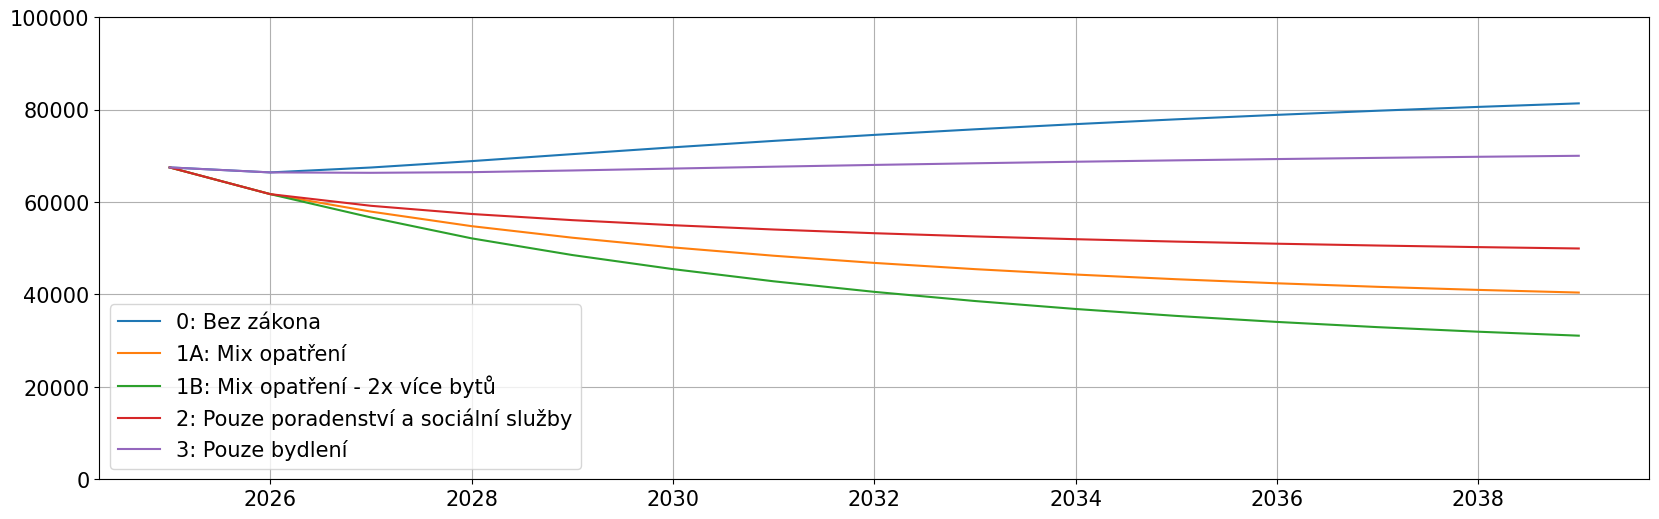

In [20]:
plot_hhs_in_emergency(output_variants,title='');

In [21]:
x = pd.DataFrame({variant['title']:variant['hhs'][['guaranteed','municipal','mop_payment','self_help','consulting','queue']].sum(axis=1) for variant in output_variants})
x.iloc[-1]/x.iloc[0]

0: Bez zákona                             1.205465
1A: Mix opatření                          0.598721
1B: Mix opatření - 2x více bytů           0.460470
2: Pouze poradenství a sociální služby    0.740073
3: Pouze bydlení                          1.037321
dtype: float64

### Náklady variant

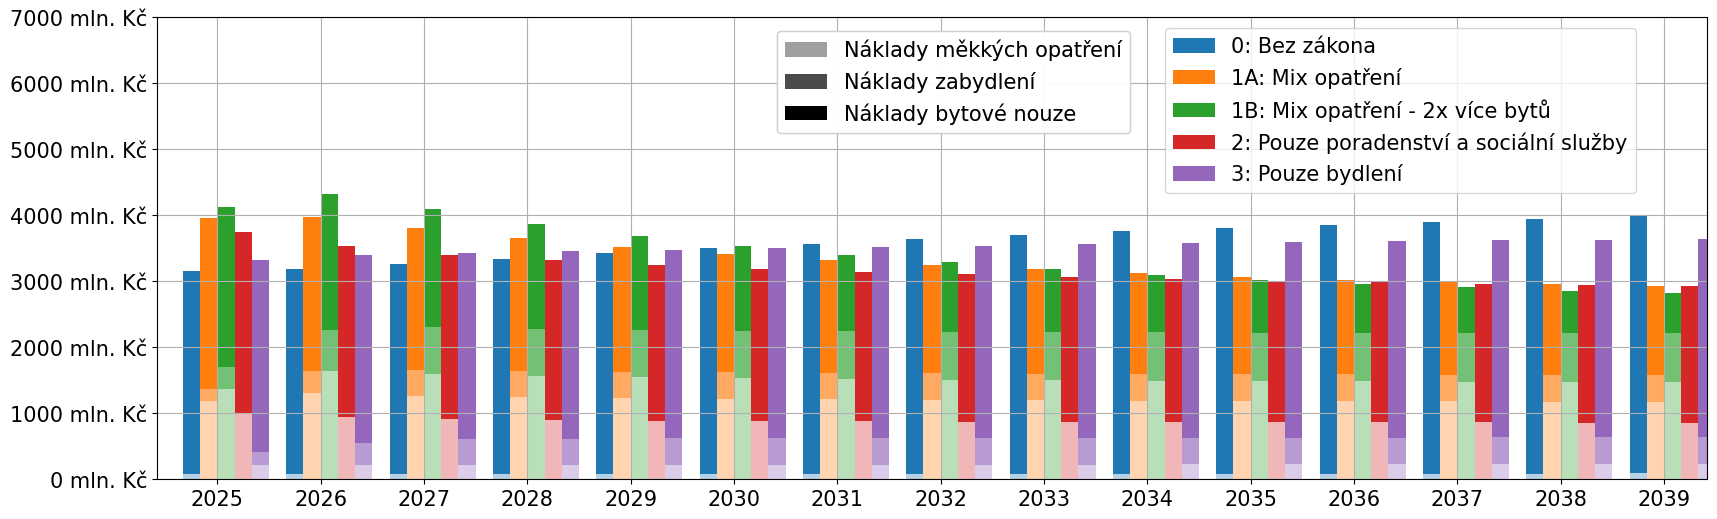

In [22]:
plot_costs_summary(
    output_variants,
    title='',key='costs'
);

### Tabulka diskontované náklady opatření a efektivita řešení

In [23]:

#npv = pd.Series({variant['title']f"{variant['costs_discounted'].drop('queue_social',axis=1).sum().sum()/1000000000:.1f} mld. Kč" for variant in output_variants})
npv = pd.Series({variant['title']:variant['costs_discounted'].drop('queue_social',axis=1).sum().sum() for variant in output_variants})

hhs_last_year = pd.Series({variant['title']:variant['hhs'][['guaranteed','municipal','mop_payment','self_help','consulting','queue']].sum(axis=1).iloc[-1] for variant in output_variants})
pd.DataFrame({
    'Čistá současná hodnota nákladů na variantu (za 15 let)':npv.apply(lambda x: f"{x/1000000000:.1f} mld. Kč"),
    'Rozdíl ČSH vůči V0 (za 15 let)': (npv - npv.loc['0: Bez zákona']).apply(lambda x: f"{x/1000000000:.1f} mld. Kč"),
    'Počet domácností v bytové nouzi po 15 letech':hhs_last_year.apply(lambda x: f"{x:.0f}")
})

,Čistá současná hodnota nákladů na variantu (za 15 let),Rozdíl ČSH vůči V0 (za 15 let),Počet domácností v bytové nouzi po 15 letech
0: Bez zákona,41.1 mld. Kč,0.0 mld. Kč,81369
1A: Mix opatření,39.3 mld. Kč,-1.8 mld. Kč,40414
1B: Mix opatření - 2x více bytů,40.4 mld. Kč,-0.7 mld. Kč,31082
2: Pouze poradenství a sociální služby,37.1 mld. Kč,-4.0 mld. Kč,49955
3: Pouze bydlení,40.6 mld. Kč,-0.5 mld. Kč,70019


In [24]:
((npv.loc['1A: Mix opatření'] - npv.loc['0: Bez zákona'])/15)/1000000

-118.13609652954102

### Náklady intervencí

In [25]:
explicit_cols = ['IT_system', 'apartments_yearly_guaranteed', 'apartments_entry_guaranteed', 'apartments_yearly_municipal', 'apartments_entry_municipal', 'consulting', 'regional_administration', 'mop_payment', 'social_assistence']

explicit_costs = OUTPUT_1A['costs'][explicit_cols]

explicit_costs.div(explicit_costs.sum(axis=1),axis=0)#.plot.bar(stacked=True,figsize=(20,6),grid=True)

,IT_system,apartments_yearly_guaranteed,apartments_entry_guaranteed,apartments_yearly_municipal,apartments_entry_municipal,consulting,regional_administration,mop_payment,social_assistence
rok,,,,,,,,,
2025,0.016103,0.069293,0.022447,0.042684,0.0,0.297839,0.041468,0.225615,0.284551
2026,0.001217,0.115217,0.018662,0.070974,0.0,0.267208,0.034475,0.148279,0.343969
2027,0.001204,0.114008,0.018466,0.105622,0.0,0.264404,0.034114,0.130621,0.331560
2028,0.001219,0.115383,0.018689,0.107396,0.0,0.267593,0.034525,0.123770,0.331425
2029,0.001228,0.116286,0.018835,0.109025,0.0,0.269686,0.034795,0.118826,0.331319
2030,0.001236,0.116987,0.018948,0.110411,0.0,0.271312,0.035005,0.114808,0.331293
2031,0.001242,0.117558,0.019041,0.111716,0.0,0.272637,0.035176,0.111365,0.331265
2032,0.001247,0.118020,0.019116,0.112923,0.0,0.273709,0.035314,0.108351,0.331322
2033,0.001251,0.118405,0.019178,0.114061,0.0,0.274600,0.035429,0.105703,0.331373


In [26]:
pd.Series({variant['title']:variant['costs'][explicit_cols].sum().sum()/1000000 for variant in output_variants})

0: Bez zákona                              1226.190967
1A: Mix opatření                          23903.220543
1B: Mix opatření - 2x více bytů           33096.813103
2: Pouze poradenství a sociální služby    13314.606439
3: Pouze bydlení                           9102.685888
dtype: float64

In [27]:
interventions = OUTPUT_1A['interventions'].stack('intervention_type').sum(axis=1).unstack('intervention_type')
(interventions.T/interventions.sum(axis=1)).T

intervention_type,consulting,guaranteed,mop_payment,municipal,self_help
rok,,,,,
2025,0.174986,0.079765,0.349971,0.045307,0.349971
2026,0.169372,0.097666,0.338744,0.055474,0.338744
2027,0.166153,0.107621,0.332306,0.061613,0.332306
2028,0.164195,0.113594,0.328391,0.065430,0.328391
2029,0.162659,0.118129,0.325319,0.068574,0.325319
2030,0.161347,0.122009,0.322695,0.071253,0.322695
2031,0.160154,0.125460,0.320308,0.073771,0.320308
2032,0.159052,0.128566,0.318103,0.076176,0.318103
2033,0.158060,0.131391,0.316120,0.078309,0.316120


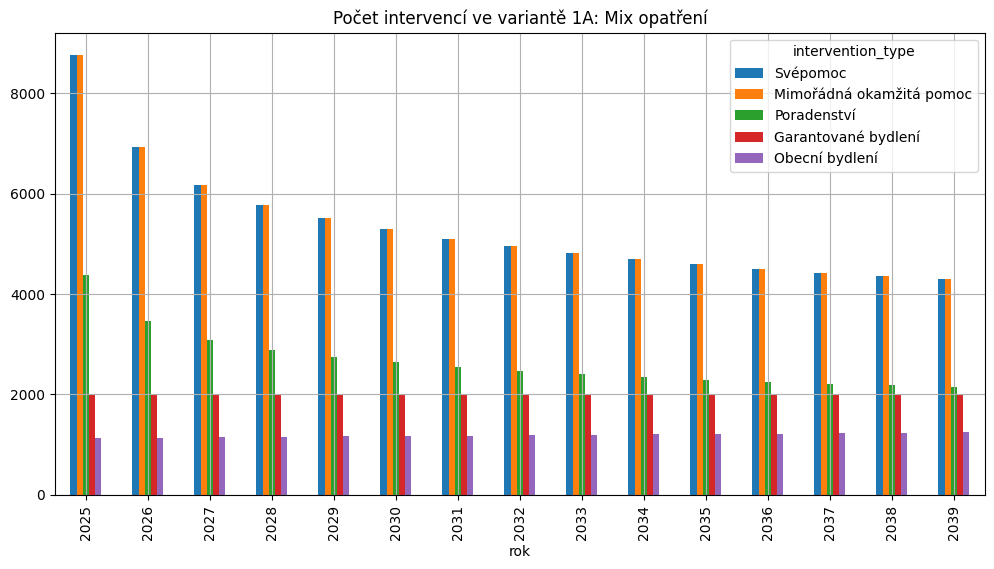

In [28]:
plot_interventions(OUTPUT_1A['interventions'], title=f'Počet intervencí ve variantě {OUTPUT_1A["title"]}')

### Domácnosti se sociální asistencí dle typu intervence

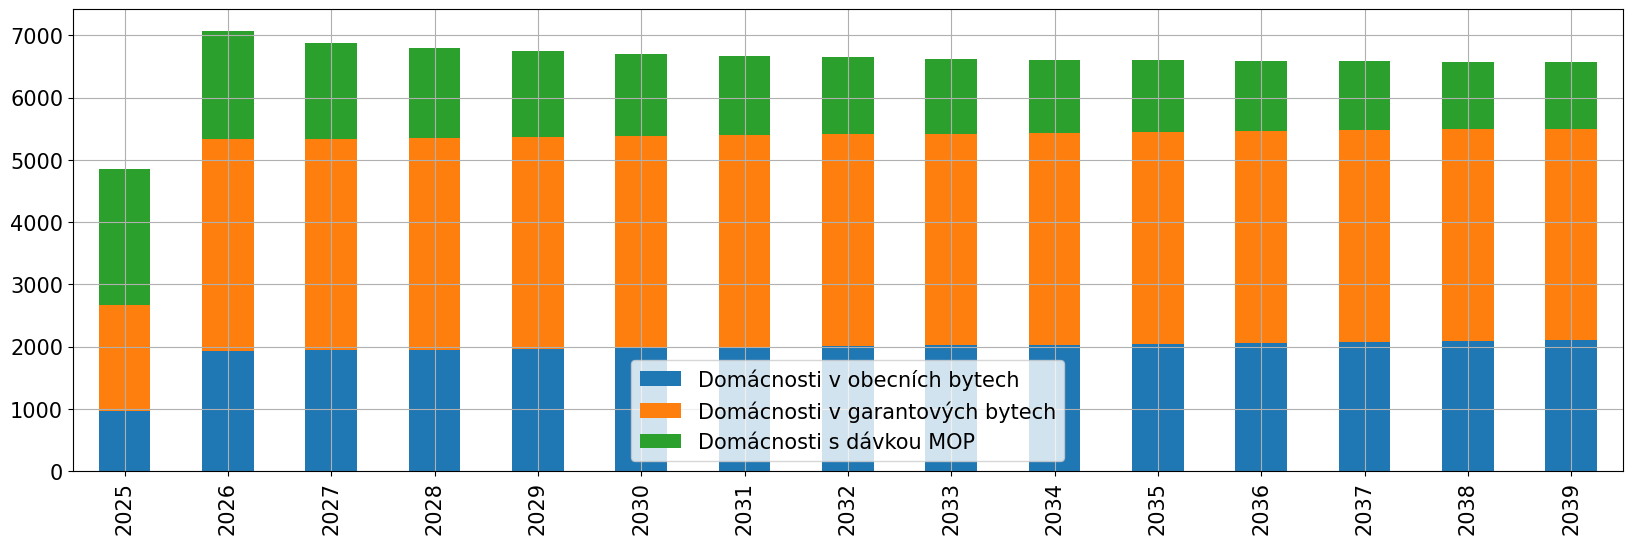

In [29]:
social = OUTPUT_1A['social_assistence_breakdown'][['municipal','guaranteed','mop_payment']].rename({
    'guaranteed':'Domácnosti v garantových bytech',
    'municipal':'Domácnosti v obecních bytech',
    'mop_payment':'Domácnosti s dávkou MOP'
},axis=1)
ax = social.plot.bar(stacked=True,figsize=(20,6),grid=True, title='', fontsize=15,xlabel='')
ax.legend(fontsize=15, loc='lower center');

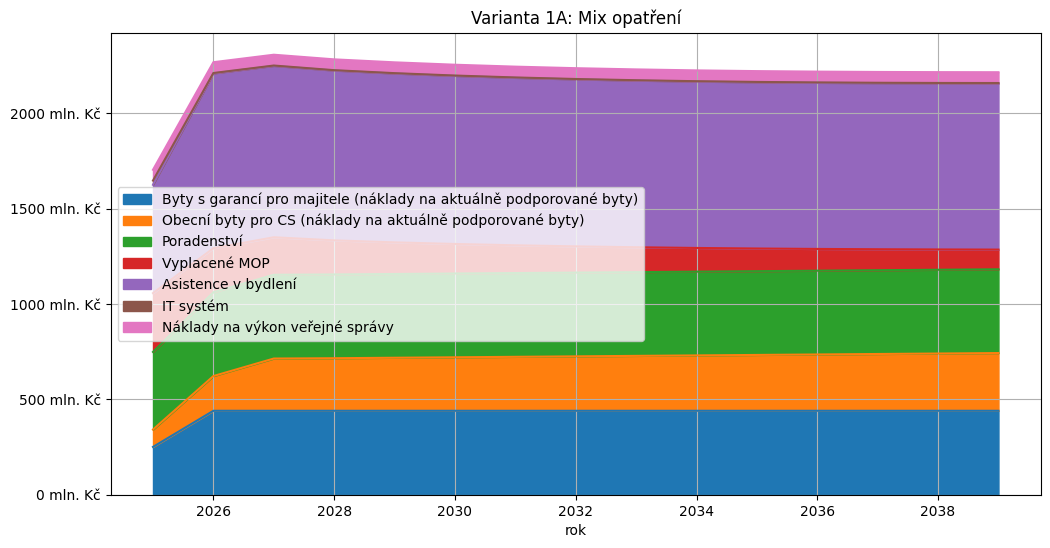

In [30]:
plot_interventions_costs(OUTPUT_1B, title=f'Varianta {OUTPUT_1A["title"]}', costs_type='costs');

Tab. X: Náklady zákona v 5. roce implementace dle Cost-Benefit analýzy (CBA) 

In [31]:
tbl_implementace = OUTPUT_1A['costs'][explicit_cols].loc[2029].copy()
tbl_implementace['guaranteed'] = tbl_implementace.apartments_yearly_guaranteed + tbl_implementace.apartments_entry_guaranteed
tbl_implementace['municipal'] = tbl_implementace.apartments_yearly_municipal + tbl_implementace.apartments_entry_municipal

tbl_implementace = tbl_implementace.drop(['apartments_yearly_guaranteed','apartments_entry_guaranteed','apartments_yearly_municipal','apartments_entry_municipal'])

tbl_cols= {
    'guaranteed':'Bydlení s garancí',
    'municipal':'Obecní podporované byty',
    'consulting':'Poradenství na obcích',
    'social_assistence':'Asistence v bydlení',
    'regional_administration':'Krajské úřady a restory (MPSV a MMR)',
    'IT_system':'IT systém',
}

tbl_implementace = tbl_implementace.rename(tbl_cols,axis=1)[tbl_cols.values()]
tbl_implementace['Celkem'] = tbl_implementace.sum()
(tbl_implementace/1000000).astype(int).apply(lambda row: f'{row} mil. Kč').to_frame()


,2029
Bydlení s garancí,219 mil. Kč
Obecní podporované byty,177 mil. Kč
Poradenství na obcích,439 mil. Kč
Asistence v bydlení,539 mil. Kč
Krajské úřady a restory (MPSV a MMR),56 mil. Kč
IT systém,2 mil. Kč
Celkem,1434 mil. Kč


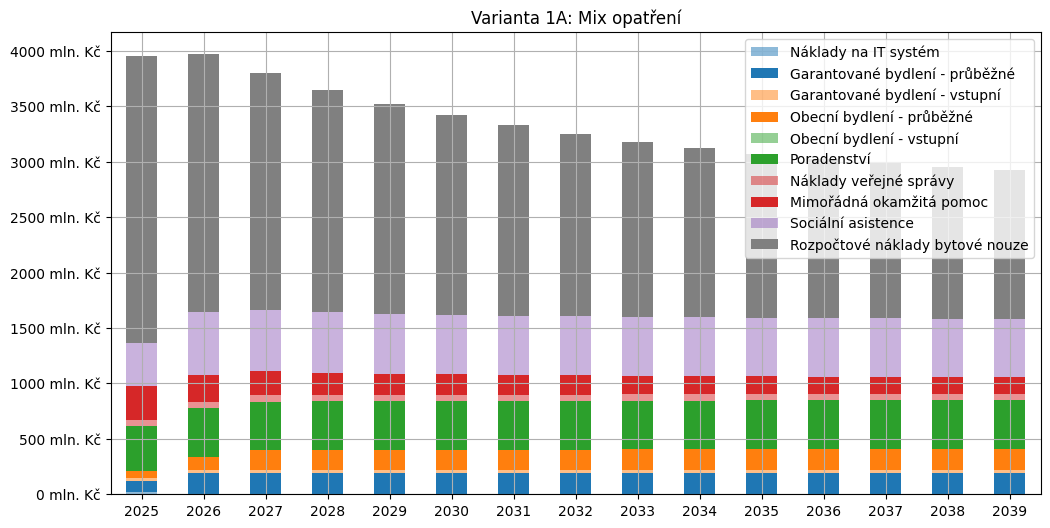

In [32]:
plot_costs(OUTPUT_1A['costs'], title=f'Varianta {OUTPUT_1A["title"]}');

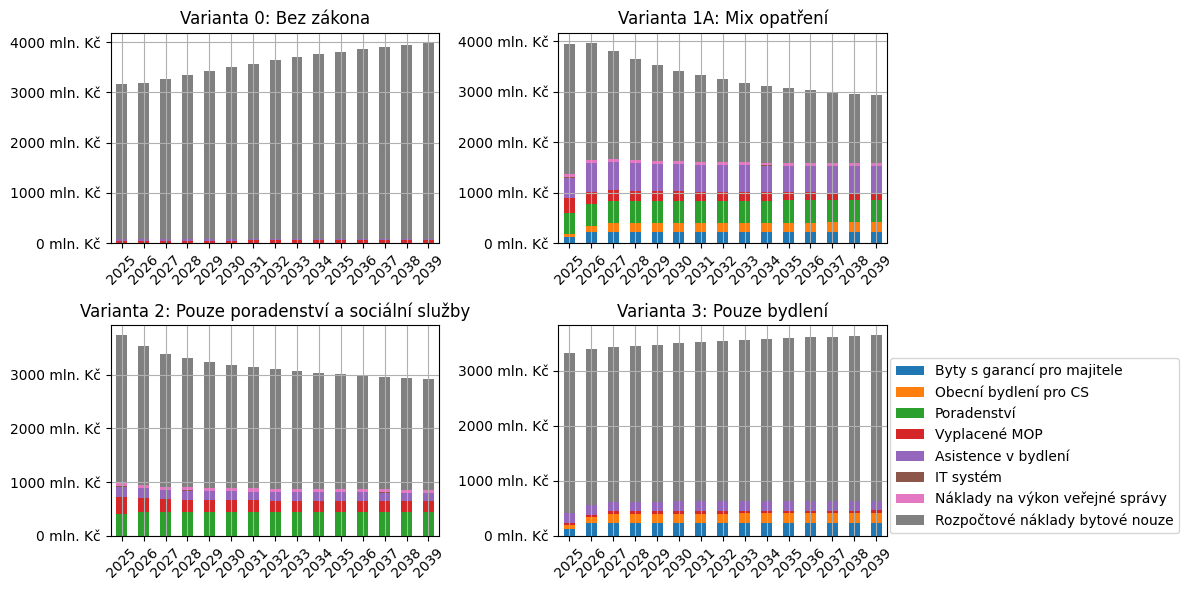

In [63]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,20))
axs[0,0] = plot_costs(OUTPUT_0['costs'], title=f'Varianta {OUTPUT_0["title"]}',ax=axs[0,0],rot=45)
axs[0,1] = plot_costs(OUTPUT_1A['costs'], title=f'Varianta {OUTPUT_1A["title"]}',ax=axs[0,1],rot=45)
axs[1,0] = plot_costs(OUTPUT_2['costs'], title=f'Varianta {OUTPUT_2["title"]}',ax=axs[1,0],rot=45)
axs[1,1] = plot_costs(OUTPUT_3['costs'], title=f'Varianta {OUTPUT_3["title"]}',ax=axs[1,1],rot=45)

axs[0,0].legend().remove()
axs[0,1].legend().remove()
axs[1,0].legend().remove()
axs[1,1].legend(loc=(1.01,0.01))
fig.tight_layout();

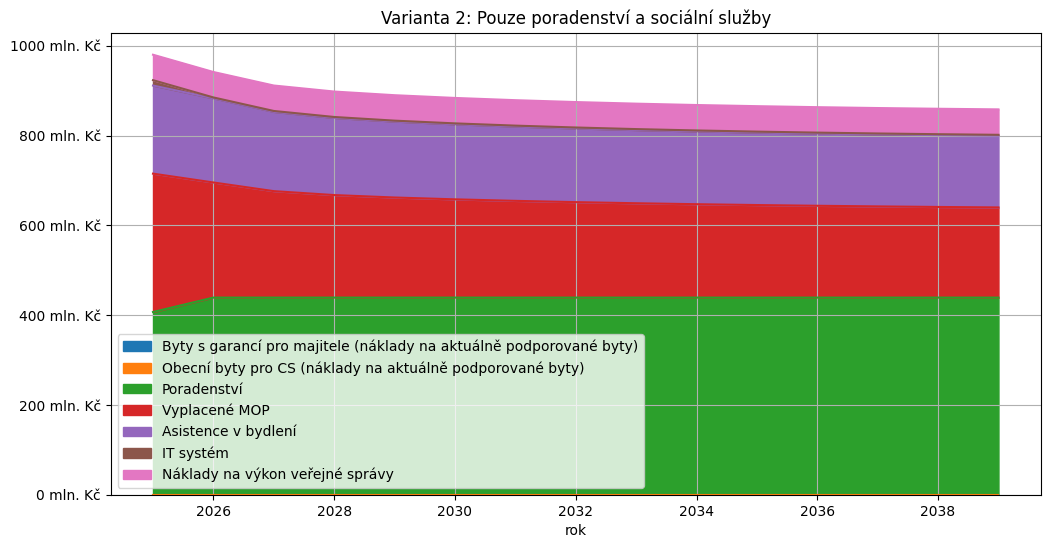

In [54]:
plot_interventions_costs(OUTPUT_2, title=f'Varianta {OUTPUT_2["title"]}', costs_type='costs');

## Role risk transferu

In [ ]:
def vary_risk_transfer_costs_summary(low_to_high_risk_shares, reference_input):
    def generate_output(low_to_high_risk_share, reference_input):
    
        new_input = copy.deepcopy(reference_input)
        new_input['low_to_high_risk_share'] = low_to_high_risk_share
        new_input['title'] = f'{new_input["low_to_high_risk_share"]*100}% low-risk ve frontě do high-risk'
        return simulate_social_housing(**new_input)
    
    outputs = [generate_output(low_to_high_risk_share, reference_input) for low_to_high_risk_share in low_to_high_risk_shares ]
    return plot_costs_summary(
        outputs,
        key='costs'
    )
    
vary_risk_transfer_costs_summary([.0,.25,.5,.75,1.], INPUT_1A);

In [ ]:
def vary_risk_transfer_hhs_emergency(low_to_high_risk_shares, reference_input):
    def generate_output(low_to_high_risk_share, reference_input):
    
        new_input = copy.deepcopy(reference_input)
        new_input['low_to_high_risk_share'] = low_to_high_risk_share
        new_input['title'] = f'{new_input["low_to_high_risk_share"]*100}% low-risk ve frontě do high-risk'
        return simulate_social_housing(**new_input)
    
    outputs = [generate_output(low_to_high_risk_share, reference_input) for low_to_high_risk_share in low_to_high_risk_shares]
    return plot_hhs_in_emergency(
        outputs,
    )
    
vary_risk_transfer_hhs_emergency([.0,.25,.5,.75,1.], INPUT_1A);

In [ ]:
INPUT_1A['years_of_support']

In [ ]:
INPUT_1A['intervention_shares'].loc['low']

In [ ]:
INPUT_1A['relapse_rates'].loc['low']

In [ ]:
INPUT_1A['hhs_inflow']

In [ ]:
OUTPUT_0['returnees'].loc[:,idx[:,'low']]

In [ ]:
OUTPUT_0['hhs'].loc[:,idx[:,'low']]

In [ ]:
OUTPUT_0['hhs']

## Nepotřebné věci schovávané hlavně kvůli tomu, kdyby se náhodou v budoucnu staly potřebnými

### Počet domácností v BN vůči počtu domácností v BN prvním roce

In [ ]:
def get_bn_count(variant, include_self_helps = False):
    bn = variant['hhs'].queue.sum(axis=1)
        
    return bn.to_frame().assign(variant=variant['title'])

bn_count = pd.concat([get_bn_count(var) for var in output_variants]).reset_index().set_index(['rok','variant']).sum(axis=1).unstack('variant')
ax = (bn_count/current_level).plot(grid=True,figsize=(20,6),fontsize=15,rot=0,xlabel='',ylim=(0,1.2))
ax.legend(fontsize=15)
ax.yaxis.set_major_formatter(PCT_FORMATTER)

In [ ]:
def get_outside_bn_count(variant, base_year=2025):
    outside_cols = [col for col in variant['hhs'].columns if col[0].startswith('outside')]
    outside = variant['hhs'][outside_cols]
    outside_low = outside.loc[:,idx[:,'low']].sum(axis=1)
    outside_high = outside.loc[:,idx[:,'high']].sum(axis=1)
    
    return pd.DataFrame({
        'Nízké riziko':outside_low, 'Vysoké riziko':outside_high
    }).assign(varianta=variant['title'])

bn_count = pd.concat([get_outside_bn_count(var) for var in output_variants]).reset_index().set_index(['varianta','rok'])#.unstack('varianta')
#ax = bn_share.plot(grid=True,figsize=(20,6),fontsize=15,rot=0,xlabel='',)
#ax.legend(fontsize=15)
plot_grouped_stacked(bn_count, color_leg_loc=[0.05, 0.62])

In [ ]:
def get_outside_bn_share(variant, base_year=2025):
    outside_cols = [col for col in variant['hhs'].columns if col[0].startswith('outside')]
    outside = variant['hhs'][outside_cols]
    outside_share = outside.loc[:,idx[:,'low']].sum(axis=1)/outside.sum(axis=1)
    
    return outside_share.to_frame().assign(variant=variant['title'])

bn_share = pd.concat([get_outside_bn_share(var) for var in output_variants]).reset_index().set_index(['rok','variant']).sum(axis=1).unstack('variant')
ax = bn_share.plot(grid=True,figsize=(20,6),fontsize=15,rot=0,xlabel='',ylim=(0,1))
ax.legend(fontsize=15)
ax.yaxis.set_major_formatter(PCT_FORMATTER)

In [ ]:
def get_queue_bn_share(variant, base_year=2025):
    bn = variant['hhs'].queue.sum(axis=1)
    high = variant['hhs'].queue.high
    
    return (high/bn).to_frame().assign(variant=variant['title'])
bn_share = pd.concat([get_queue_bn_share(var) for var in output_variants]).reset_index().set_index(['rok','variant']).sum(axis=1).unstack('variant')
bn_share.plot(grid=True,figsize=(20,6),fontsize=15,rot=0,xlabel='')

### Rozpočtové náklady variant řešení sociálního bydlení dle typu nákladu

In [ ]:
plot_costs_summary(
    [OUTPUT_0, OUTPUT_1A],
    title='',key='costs'
)

### Skutečné náklady na řešení

### Kumulované diskontované náklady nad rámec V0

In [ ]:
costs_summary = get_costs_summary(output_variants,key='costs_discounted')
x = costs_summary.sum(axis=1).unstack('varianta')
(x[['1A: Mix opatření','1B: Mix opatření - 2x více bytů','2: Pouze poradenství a sociální služby']].T - x['0: Bez zákona']).T#.cumsum().plot.bar(figsize=(20,6),grid=True,fontsize=15,rot=0)

### Náklady na opatření v zákoně (v milionech Kč) bez zohlednění nákladů bytovou nouzi

In [ ]:
plot_interventions_costs(OUTPUT_1A, title='', costs_type='costs');

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1,sharey=True)

plot_interventions_costs(OUTPUT_1A, title='Varianta 1A', costs_type='costs', ax=axs[0],legend=False)
plot_interventions_costs(OUTPUT_2, title='Varianta 2', costs_type='costs', ax=axs[1],legend=True)

In [ ]:
cs_disc = get_costs_summary(output_variants,key='costs_discounted').sum(axis=1).unstack('varianta')
cs_disc['1A: Mix opatření'].sum()/cs_disc['0: Bez zákona'].sum()

In [ ]:
cs_disc = get_costs_summary(output_variants,key='costs_discounted').sum(axis=1).unstack('varianta')



pd.DataFrame({variant['title']: variant['hhs'][[col for col in variant['hhs'].columns if col[0].startswith('outside')]].sum(axis=1) for variant in output_variants}).iloc[-1]

In [ ]:
náklady_na_intervence = get_costs_summary(output_variants,key='costs_discounted')[['Náklady měkkých opatření','Náklady zabydlení']].sum(axis=1).unstack('varianta').sum()
náklady_na_intervence

In [ ]:
plot_interventions_costs(OUTPUT_3, title='')

In [ ]:
costs_over_V0 = cs_disc.sum() - cs_disc['0: Bez zákona'].sum()
bn_outside = pd.DataFrame({variant['title']: variant['hhs'][[col for col in variant['hhs'].columns if col[0].startswith('outside') and col[0] != 'outside_self_help' ]].sum(axis=1) for variant in output_variants}).iloc[-1]
náklady_na_intervence = get_costs_summary(output_variants,key='costs_discounted')[['Náklady měkkých opatření','Náklady zabydlení']].sum(axis=1).unstack('varianta').sum()

pd.DataFrame({
    'Celkové náklady varianty':cs_disc.sum(),
    'Náklady na nástroje řešení BN':náklady_na_intervence,
    'Počet vyřešených případů BN':bn_outside,
})
#ax.yaxis.set_major_formatter(MLN_FORMATTER)

In [ ]:
x = (cs_disc.sum()/1000000000)
x1 = x/x.loc['0: Bez zákona']
x2 = (x - x.loc['0: Bez zákona'])

pd.DataFrame({'Celkové náklady zavedení systému':x, 'Rozdíl vůči V0':x2, '%':x1})

### Náklady na pomoc bytonouzákovi

In [ ]:
def costs_per_hh_out(variants):
    def _get_costs_per_hh_out(variant):
        
        outside_bn = variant['hhs'][[col for col in variant['hhs'].columns if col[0].startswith('outside_')]].sum(axis=1)
        explicit_costs = ['IT_system', 'apartments_yearly_guaranteed', 'apartments_entry_guaranteed', 'apartments_yearly_municipal', 'apartments_entry_municipal', 'consulting', 'regional_administration', 'mop_payment', 'social_assistence']
        costs_cumsum = variant['costs'][explicit_costs].sum(axis=1).cumsum()
        
        return pd.DataFrame({'outside_bn':outside_bn, 'costs_cumsum':costs_cumsum, 'share':(costs_cumsum/outside_bn)}).assign(variant=variant['title']).reset_index().set_index(['variant','rok'])
    
    return pd.concat([_get_costs_per_hh_out(variant) for variant in variants])
costs_per_hh_out(output_variants).share.unstack('variant').plot.bar(figsize=(20,6),grid=True, title='Počet korun utracených na dostání 1 domácnosti z BN (kumulativně)')

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=1)
axs[0] = plot_costs(OUTPUT_0['costs'], ax=axs[0], title=f'{OUTPUT_0["title"]} - Náklady') # , figsize=None, include_queue_budget=True, include_queue_social=False,ylim=ylim_costs
axs[1] = plot_costs(OUTPUT_1A['costs'], ax=axs[1], title=f'{OUTPUT_1A["title"]} - Náklady', figsize=None) # , include_queue_budget=True, include_queue_social=False,ylim=ylim_costs
axs[0].get_legend().remove()
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

### Pro podrobnější zkoumání lze exportovat data z jednotlivých simulací do XLSX

In [ ]:
save_tables_to_excel(
    output_variants,
    'hlavni_varianty.xlsx'
)

## Detailní srovnání variant

In [ ]:
compare_variants(OUTPUT_0, OUTPUT_1A);

In [ ]:
compare_variants(OUTPUT_0, OUTPUT_1A, discount_costs=False);

## Příklad: Častější MOPky

In [ ]:
input_default = copy.deepcopy(INPUT_1A)
input_default['title'] = 'Podíl MOP: 10 % u high a 20 % u low'
output_default = simulate_social_housing(**default_variant)

variant_more_mops = copy.deepcopy(default_variant)
variant_more_mops['intervention_shares'].loc['high','mop_payment'] = variant_more_mops['intervention_shares'].loc['high','mop_payment'] * 2
variant_more_mops['intervention_shares'].loc['low','mop_payment'] = variant_more_mops['intervention_shares'].loc['low','mop_payment'] * 2
variant_more_mops['title'] = 'Podíl MOP: 20 % u high a 40 % u low'
output_more_mops = simulate_social_housing(**variant_more_mops)
compare_variants(output_default, output_more_mops);

### Pokus shrnující plot skrze domácnost

In [ ]:
plot_hhs_in_emergency(output_variants);


### Grafíky pro Vítka Lesáka
### Počet jednotlivých intervencí

In [ ]:
def get_interventions_counts(model_output, title, base_year=2025):
    df = model_output['costs_units'].assign(rok=lambda row: pd.Series(row.index) + base_year).set_index('rok')
    return pd.DataFrame({
        'Byty s garancí pro majitele (počet aktuálně podporovaných bytů)': df.apartments_yearly_guaranteed,
        'Obecní byty pro CS (počet aktuálně podporovaných bytů)':  df.apartments_yearly_municipal,
        'Poradenství (počet domácností)': df.consulting,
        'Vyplacené MOP (počet)': df.mop_payment,
        'Asistence v bydlení (počet domácností)': df.social_assistance
    }).plot.line(
        style='.-',
        grid=True,
        figsize=(12,6),
        title=title
    )

get_interventions_counts(OUTPUT_1_PESIMISTIC, title='Počet jednotlivých intervencí - Realistická varianta')

#### Celkové náklady na opatření a bytovou nouzi

In [ ]:
def plot_total_costs(model_output_v0,model_output_v1, title, base_year=2025, costs_type='costs_discounted'):
    v0 = model_output_v0[costs_type].assign(rok=lambda row: pd.Series(row.index) + base_year).set_index('rok')
    v1 = model_output_v1[costs_type].assign(rok=lambda row: pd.Series(row.index) + base_year).set_index('rok')
    
    interventions = ['IT_system','apartments_yearly_guaranteed','apartments_entry_guaranteed','apartments_yearly_municipal','apartments_entry_municipal','consulting','regional_administration','mop_payment','social_assistence']
    
    ax = pd.DataFrame({
        'Náklady na nástroje V0':v0[interventions].sum(axis=1),
        'Náklady na bytovou nouzi V0':v0.queue_budget,
        'Celkové náklady V0':v0[interventions].sum(axis=1) + v0.queue_budget,
        'Náklady na nástroje V1':v1[interventions].sum(axis=1),
        'Náklady na bytovou nouzi V1':v1.queue_budget,
        'Celkové náklady V1':v1[interventions].sum(axis=1) + v1.queue_budget
    }).plot.line(
        style='.-',
        grid=True,
        figsize=(12,6),
        title=title
    )
    ax.yaxis.set_major_formatter(MLN_FORMATTER)
    return ax
plot_total_costs(OUTPUT_0_PESIMISTIC, OUTPUT_1_PESIMISTIC, title='Celkové náklady na opatření a na bytovou nouzi (v milionech Kč) - Realistická varianta')

#### Náklady na opatření v zákoně (v milionech Kč) - Realistická varianta, bez zohlednění nákladů na Variantu 0 (bez zákona)

In [ ]:
plot_interventions_costs(OUTPUT_1A, title='Náklady na opatření v zákoně (v milionech Kč) bez zohlednění nákladů bytovou nouzi')

### Shrnutí vstupů dle intervencí (tabulky do RIA)

#### Intervention share

In [ ]:
intervention = 'self_help'
optimistic_inputs = [INPUT_0_PESIMISTIC, INPUT_1_PESIMISTIC, INPUT_2_PESIMISTIC, INPUT_3_PESIMISTIC]

pd.concat({variant['title']:variant['intervention_shares'][intervention] for variant in optimistic_inputs},axis=1).T[['low','high']]

In [ ]:
intervention = 'self_help'
optimistic_inputs = [INPUT_0_OPTIMISTIC, INPUT_1_OPTIMISTIC, INPUT_2_OPTIMISTIC, INPUT_3_OPTIMISTIC]


pd.concat({variant['title']:variant['relapse_rates'][intervention] for variant in optimistic_inputs},axis=1).T[['low','high']]

In [ ]:
INPUT_0_OPTIMISTIC['social_assistences']

In [ ]:
intervention = 'mop_payment'
optimistic_inputs = [INPUT_0_OPTIMISTIC, INPUT_1_OPTIMISTIC, INPUT_2_OPTIMISTIC, INPUT_3_OPTIMISTIC]


pd.concat({variant['title']:variant['social_assistences'].loc[intervention] for variant in optimistic_inputs},axis=1).T

### 

### Proč dělat i bydlení?  Co si kupujeme v 1A vs. 2? 

In [ ]:
def get_outside_bn_count(variant, base_year=2025):
    outside_cols = [col for col in variant['hhs'].columns if col[0].startswith('outside')]
    outside = variant['hhs'][outside_cols]
    outside_low = outside.loc[:,idx[:,'low']].sum(axis=1)
    outside_high = outside.loc[:,idx[:,'high']].sum(axis=1)
    
    return pd.DataFrame({
        'Nízké riziko':outside_low, 'Vysoké riziko':outside_high
    }).assign(varianta=variant['title'], rok=lambda x: x.index + base_year)

bn_count = pd.concat([get_outside_bn_count(var) for var in [OUTPUT_1A, OUTPUT_2]]).set_index(['varianta','rok'])#.unstack('varianta')
#ax = bn_share.plot(grid=True,figsize=(20,6),fontsize=15,rot=0,xlabel='',)
#ax.legend(fontsize=15)
plot_grouped_stacked(bn_count, color_leg_loc=[0.05, 0.75])

In [ ]:
x = bn_count.stack().unstack('varianta')
(x['1A: Mix opatření'] - x['2: Pouze poradenství a sociální služby']).unstack(1).plot.bar(stacked=True, grid=True,title='Počet domácností venku z BN (kumulativně)')

In [ ]:
plot_costs_summary([OUTPUT_1A, OUTPUT_2],key='costs')

In [ ]:
def get_high_risk_count_at_end(variant ):
    outside_cols = [col for col in variant['hhs'].columns if col[0].startswith('outside')]
    outside_high = variant['hhs'][outside_cols].loc[:,idx[:,'high']].sum(axis=1)
    outside_low = variant['hhs'][outside_cols].loc[:,idx[:,'low']].sum(axis=1)
    
    return pd.Series({'high':outside_high.iloc[-1],'low':outside_low.iloc[-1]})
        

def vary_low_to_high_risk_share(options, reference_variant_input):
    

    output = {}
    for param in options:
        
        new_input = copy.deepcopy(reference_variant_input)
        new_input['low_to_high_risk_share'] = param
        
        new_output = simulate_social_housing(**new_input)
        
        output[param] = get_high_risk_count_at_end(new_output)

    return pd.DataFrame(output)

x1A = vary_low_to_high_risk_share(np.arange(0,1.05,.05), INPUT_1A).T#.plot()
x1A.plot(grid=True,ylim=(0,100000))

In [ ]:
x2 = vary_low_to_high_risk_share(np.arange(0,1.05,.05), INPUT_2).T
x2.plot(grid=True,ylim=(0,100000))